# Summary:
This notebook contains the regularized iterative hard smoothing for Amherst (Figure 4, lower right).

## load libraries

In [20]:
# import packages
from __future__ import division

import networkx as nx
import os
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import itertools

from numpy.linalg import inv

## function to create + save dictionary of features
def create_dict(key, obj):
    return(dict([(key[i], obj[i]) for i in range(len(key))]))

## load helper functions and datasets

In [21]:
# set the working directory and import helper functions
#get the current working directory and then redirect into the functions under code 
cwd = os.getcwd()

# parents working directory of the current directory: which is the code folder
parent_cwd = os.path.dirname(cwd)
# get into the functions folder
functions_cwd = parent_cwd + '/functions'
# change the working directory to be .../functions
os.chdir(functions_cwd)

# import all helper functions
exec(open('parsing.py').read())
exec(open('ZGL.py').read())
exec(open('create_graph.py').read())
exec(open('iterative_method_test.py').read())
exec(open('iterative_method_ZGL_regularized.py').read())


# import the data from the data folder
data_cwd = os.path.dirname(parent_cwd)+ '/data'

# change the working directory and import the fb dataset
fb100_file = data_cwd +'/Amherst41'

A, metadata = parse_fb100_mat_file(fb100_file)

# change A(scipy csc matrix) into a numpy matrix
adj_matrix_tmp = A.todense()
#get the gender for each node(1/2,0 for missing)
gender_y_tmp = metadata[:,1] 
# get the corresponding gender for each node in a disctionary form
gender_dict = create_dict(range(len(gender_y_tmp)), gender_y_tmp)

(graph, gender_y)  = create_graph(adj_matrix_tmp,gender_dict,'gender',0,None,'yes') 

## general setup

In [22]:
percent_initially_unlabelled = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05] 
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled) 
n_iter = 10
cv_setup='stratified'

## regularized iterative hard smoothing update (regularized iterative ZGL)

In [24]:
n = len(gender_y)
keys = list(graph.node)


# see how many classes are there and rearrange them
classes = np.sort(np.unique(gender_y))
class_labels = np.array(range(len(classes)))


# relabel membership class labels - for coding convenience
# preserve ordering of original class labels -- but force to be in sequential order now
gender_y_update = np.copy(gender_y)
for j in range(len(classes)):
    gender_y_update[gender_y_update == classes[j]] = class_labels[j]

gender_y_update = np.array(gender_y_update)

mean_accuracy_one = []
se_accuracy_one = []

mean_micro_auc_one = []
se_micro_auc_one = []

mean_wt_auc_one = []
se_wt_auc_one = []



mean_accuracy_two = []
se_accuracy_two = []

mean_micro_auc_two = []
se_micro_auc_two = []

mean_wt_auc_two = []
se_wt_auc_two = []




mean_accuracy_iter2 = []
se_accuracy_iter2 = []

mean_micro_auc_iter2 = []
se_micro_auc_iter2 = []

mean_wt_auc_iter2 = []
se_wt_auc_iter2 = []



mean_accuracy_iter3 = []
se_accuracy_iter3 = []

mean_micro_auc_iter3 = []
se_micro_auc_iter3 = []

mean_wt_auc_iter3 = []
se_wt_auc_iter3 = []



mean_accuracy_iter4 = []
se_accuracy_iter4 = []

mean_micro_auc_iter4 = []
se_micro_auc_iter4 = []

mean_wt_auc_iter4 = []
se_wt_auc_iter4 = []


mean_accuracy_iter5 = []
se_accuracy_iter5 = []

mean_micro_auc_iter5 = []
se_micro_auc_iter5 = []

mean_wt_auc_iter5 = []
se_wt_auc_iter5 = []


(graph_new, gender_y_new)  = create_graph(adj_matrix_tmp,gender_dict,'gender',0,None,'yes')
adj_matrix_gender = np.array(nx.adjacency_matrix(graph_new).todense()) 
    
    
gender_dict_input = create_dict(range(len(gender_y_new)), gender_y_new)
    
(graph_input, gender_y_input)  = create_graph(adj_matrix_gender,gender_dict_input,'gender',5,None,'yes')
adj_matrix_input = np.array(nx.adjacency_matrix(graph_input).todense()) 




for i in range(len(percent_initially_labelled)):
    print(percent_initially_unlabelled[i]) 

    keys = list(graph_input.node())
    #print(keys)

    bench_mark = np.mean(np.array(gender_y_input) == np.max(class_labels))

    if cv_setup=='stratified':
        k_fold = StratifiedShuffleSplit(n_splits=n_iter,test_size=percent_initially_unlabelled[i],
                                                     random_state=1)

    else:
        k_fold = cross_validation.ShuffleSplit(n_splits=n_iter,
                                           test_size=percent_initially_unlabelled[i],
                                           random_state=None)
    accuracy_one = [] 
    micro_auc_one = []
    wt_auc_one = []
    
    
    accuracy_two = [] 
    micro_auc_two = []
    wt_auc_two = []

    accuracy_iter2 = [] 
    micro_auc_iter2 = []
    wt_auc_iter2 = []
    
    accuracy_iter3 = [] 
    micro_auc_iter3 = []
    wt_auc_iter3 = []
    
    accuracy_iter4 = [] 
    micro_auc_iter4 = []
    wt_auc_iter4 = []
     
    accuracy_iter5 = [] 
    micro_auc_iter5 = []
    wt_auc_iter5 = []
    
    

    
    # update rule for theta
    for train_index, test_index in k_fold.split(keys, gender_y_input):
        accuracy_score_benchmark = np.mean(np.array(gender_y_input)[train_index] == np.max(class_labels))

        # get 2-hop result(iteration 1)
        bench_mark = gender_y_input/len(gender_y_input)
        (theta_two_tmp, micro_auc_two_tmp, wt_auc_two_tmp, accuracy_two_tmp) = iterative_method_ZGL_regularized(1, graph_input, gender_y_input, gender_y_input, train_index, test_index)
        accuracy_two.append(accuracy_two_tmp)
        micro_auc_two.append(micro_auc_two_tmp)
        wt_auc_two.append(wt_auc_two_tmp)
        # get iteration 2 result
        #bench_mark = gender_y_input/len(gender_y_input)
        (theta_iter2_tmp, micro_auc_iter2_tmp, wt_auc_iter2_tmp, accuracy_iter2_tmp) = iterative_method_ZGL_regularized(2, graph_input, gender_y_input, theta_two_tmp, train_index, test_index)
        accuracy_iter2.append(accuracy_iter2_tmp)
        micro_auc_iter2.append(micro_auc_iter2_tmp)
        wt_auc_iter2.append(wt_auc_iter2_tmp)
        # get iteration 3 result        
        (theta_iter3_tmp, micro_auc_iter3_tmp, wt_auc_iter3_tmp, accuracy_iter3_tmp) = iterative_method_ZGL_regularized(3, graph_input, gender_y_input, theta_iter2_tmp, train_index, test_index)
        accuracy_iter3.append(accuracy_iter3_tmp)
        micro_auc_iter3.append(micro_auc_iter3_tmp)
        wt_auc_iter3.append(wt_auc_iter3_tmp)
        
        # get iteration 4 result        
        (theta_iter4_tmp, micro_auc_iter4_tmp, wt_auc_iter4_tmp, accuracy_iter4_tmp) = iterative_method_ZGL_regularized(4, graph_input, gender_y_input, theta_iter3_tmp, train_index, test_index)
        accuracy_iter4.append(accuracy_iter4_tmp)
        micro_auc_iter4.append(micro_auc_iter4_tmp)
        wt_auc_iter4.append(wt_auc_iter4_tmp)        
        
        # get iteration 5 result        
        (theta_iter5_tmp, micro_auc_iter5_tmp, wt_auc_iter5_tmp, accuracy_iter5_tmp) = iterative_method_ZGL_regularized(5, graph_input, gender_y_input, theta_iter4_tmp, train_index, test_index)
        accuracy_iter5.append(accuracy_iter5_tmp)
        micro_auc_iter5.append(micro_auc_iter5_tmp)
        wt_auc_iter5.append(wt_auc_iter5_tmp) 
      
        
        
    
    # get the mean and standard deviation for 2-hop MV
    mean_accuracy_two.append(np.mean(accuracy_two))  
    se_accuracy_two.append(np.std(accuracy_two)) 
        
    mean_micro_auc_two.append(np.mean(micro_auc_two))
    se_micro_auc_two.append(np.std(micro_auc_two))
    
    mean_wt_auc_two.append(np.mean(wt_auc_two))
    se_wt_auc_two.append(np.std(wt_auc_two)) 

    
    # get the mean and standard deviation for iter 2
    mean_accuracy_iter2.append(np.mean(accuracy_iter2))  
    se_accuracy_iter2.append(np.std(accuracy_iter2)) 
        
    mean_micro_auc_iter2.append(np.mean(micro_auc_iter2))
    se_micro_auc_iter2.append(np.std(micro_auc_iter2))
    
    mean_wt_auc_iter2.append(np.mean(wt_auc_iter2))
    se_wt_auc_iter2.append(np.std(wt_auc_iter2))
    
    # get the mean and standard deviation for iter 3
    mean_accuracy_iter3.append(np.mean(accuracy_iter3))  
    se_accuracy_iter3.append(np.std(accuracy_iter3)) 
        
    mean_micro_auc_iter3.append(np.mean(micro_auc_iter3))
    se_micro_auc_iter3.append(np.std(micro_auc_iter3))
    
    mean_wt_auc_iter3.append(np.mean(wt_auc_iter3))
    se_wt_auc_iter3.append(np.std(wt_auc_iter3)) 
    
    # get the mean and standard deviation for iter 4
    mean_accuracy_iter4.append(np.mean(accuracy_iter4))  
    se_accuracy_iter4.append(np.std(accuracy_iter4)) 
        
    mean_micro_auc_iter4.append(np.mean(micro_auc_iter4))
    se_micro_auc_iter4.append(np.std(micro_auc_iter4))
    
    mean_wt_auc_iter4.append(np.mean(wt_auc_iter4))
    se_wt_auc_iter4.append(np.std(wt_auc_iter4)) 

    # get the mean and standard deviation for iter 5
    mean_accuracy_iter5.append(np.mean(accuracy_iter5))  
    se_accuracy_iter5.append(np.std(accuracy_iter5)) 
        
    mean_micro_auc_iter5.append(np.mean(micro_auc_iter5))
    se_micro_auc_iter5.append(np.std(micro_auc_iter5))
    
    mean_wt_auc_iter5.append(np.mean(wt_auc_iter5))
    se_wt_auc_iter5.append(np.std(wt_auc_iter5))
    

0.99


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.95


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.9


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

0.8


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.7


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

0.6


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

0.5


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

0.4


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

0.3


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

0.2


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.1


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.05


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


## hard smoothing method (ZGL)

In [11]:
# ZGL
(mean_accuracy_zgl_amherst, se_accuracy_zgl_amherst, 
mean_micro_auc_zgl_amherst,se_micro_auc_zgl_amherst, 
mean_wt_auc_zgl_amherst,se_wt_auc_zgl_amherst) =ZGL(np.array(adj_matrix_input),
                                    np.array(gender_y),percent_initially_unlabelled, 
                                    n_iter,cv_setup)

0.99


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


## plot

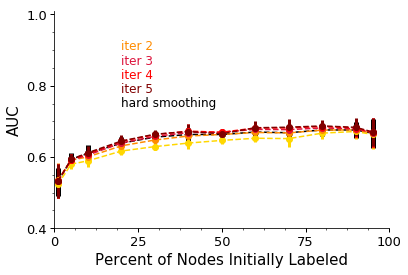

In [25]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter

fig = plt.figure()
#seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')
for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.4, 0.5,0.6,0.7,0.8,0.9,1]))

        
        
                
        grid[i].errorbar(percent_initially_labelled*100,mean_wt_auc_zgl_amherst ,
            yerr=se_wt_auc_zgl_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=5, color='black') 
        
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_two, 
            yerr=se_wt_auc_two, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='gold')
    
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter2, 
            yerr=se_wt_auc_iter2, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='darkorange')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter3, 
            yerr=se_wt_auc_iter3, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='crimson')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter4, 
            yerr=se_wt_auc_iter4, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='red') 
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter5, 
            yerr=se_wt_auc_iter5, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='maroon') 
        
         
     
        
        grid[i].set_ylim(0.3,1.1)
        grid[i].set_xlim(0,101)
     
    

    

        grid[i].annotate('iter 2', xy=(20, 0.90), 
                 color='darkorange', alpha=1, size=12)
        grid[i].annotate('iter 3', xy=(20, 0.86), 
                 color='crimson', alpha=1, size=12)
        
        grid[i].annotate('iter 4', xy=(20, 0.82), 
                 color='red', alpha=1, size=12)

        grid[i].annotate('iter 5', xy=(20, 0.78), 
                 color='maroon', alpha=1, size=12)

        grid[i].annotate('hard smoothing', xy=(20, 0.74), 
                 color='black', alpha=1, size=12)    
    
      

        grid[i].set_ylim(0.4,1.01)
        grid[i].set_xlim(0,100)
                         
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=13)
        grid[i].tick_params(axis='both', which='minor', labelsize=13)
        grid[i].set_xlabel('Percent of Nodes Initially Labeled').set_fontsize(15)
        grid[i].set_ylabel('AUC').set_fontsize(15)

grid[0].set_xticks([0,25, 50, 75, 100])
grid[0].set_yticks([ 0.4,0.6,0.8,1])


grid[0].minorticks_on()
grid[0].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
